# SNN with BindsNet
This notebook is based on bindsnet example script "Supervised_mnist.py"
and modified to use kaggle MNIST dataset.

See [https://github.com/BindsNET/bindsnet/tree/master/examples/mnist](https://github.com/BindsNET/bindsnet/tree/master/examples/mnist)

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('.\kaggle\input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

.\kaggle\input\digit-recognizer\sample_submission.csv
.\kaggle\input\digit-recognizer\test.csv
.\kaggle\input\digit-recognizer\train.csv


  Cloning https://github.com/BindsNET/bindsnet.git to c:\users\msghu\appdata\local\temp\pip-req-build-uz8glwwm
  Resolved https://github.com/BindsNET/bindsnet.git to commit 9ba4aba7d4b14ddbca7aa682f480830fd57b29d2
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached gymnasium-0.27.1-py3-none-any.whl (883 kB)
  Using cached scikit_build-0.12.0-py2.py3-none-any.whl (73 kB)
  Using cached scikit_learn-0.24.2-cp39-cp39-win_amd64.whl (6.9 MB)
  Using cached torch-1.13.0-cp39-cp39-win_amd64.whl (167.2 MB)
  Using cached torchaudio-0.13.0-cp39-cp39-win_amd64.whl (2.1 MB)
  Using cached foolbox-3.3.3-py3-none-any.whl (1.7 MB)
  Using cached Cython-0.29.33-py2.py3-none-any.whl (987 kB)
  Using cached scikit_

  Running command git clone --filter=blob:none --quiet https://github.com/BindsNET/bindsnet.git 'C:\Users\msghu\AppData\Local\Temp\pip-req-build-uz8glwwm'
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip available: 22.2.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
import os
import matplotlib.pyplot as plt
import numpy as np
import gc

import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torchvision
from tqdm.notebook import tqdm

from bindsnet.analysis.plotting import (
    plot_assignments,
    plot_input,
    plot_performance,
    plot_spikes,
    plot_voltages,
    plot_weights,
)
from bindsnet.datasets import MNIST
from bindsnet.encoding import PoissonEncoder
from bindsnet.evaluation import all_activity, assign_labels, proportion_weighting
from bindsnet.models import DiehlAndCook2015
from bindsnet.network.monitors import Monitor
from bindsnet.utils import get_square_assignments, get_square_weights

from sklearn.model_selection import train_test_split

ModuleNotFoundError: No module named 'bindsnet'

# Load train and test data

In [4]:
train = pd.read_csv(r"../input/digit-recognizer/train.csv", dtype=np.float32)
test = pd.read_csv(r"../input/digit-recognizer/test.csv", dtype=np.float32)
submission = pd.read_csv("../input/digit-recognizer/sample_submission.csv")

data_train = (train.loc[:, train.columns != "label"].values/255.).reshape(-1, 28, 28)
label_train = train.label.values
X_test = (test.values/255.).reshape(-1, 28, 28)

X_train, X_valid, y_train, y_valid = train_test_split(
                                                      data_train,
                                                      label_train,
                                                      test_size=0.2,
                                                      shuffle=True,
                                                      random_state=2021
                                                     ) 
X_train = torch.from_numpy(X_train)
y_train = torch.from_numpy(y_train).type(torch.LongTensor)

X_valid = torch.from_numpy(X_valid)
y_valid = torch.from_numpy(y_valid).type(torch.LongTensor)

X_test = torch.from_numpy(X_test)

del train, data_train, label_train

# Preprocessing and encoding of dataset for SNN input

In [5]:
n_train = len(y_train)
n_test = 100
time = 250
dt = 1.0
intensity = 32

transform=transforms.Compose([transforms.Lambda(lambda x: x * intensity)])

train_dataset = []
for i in range(n_train):
    train_dataset.append({"image":X_train[i], "encoded_image": PoissonEncoder(time=time, dt=dt)(transform((X_train[i]).reshape(-1, 28, 28))), "label": y_train[i]})

valid_dataset = []
for i in range(n_test):
    valid_dataset.append({"image":X_valid[i], "encoded_image": PoissonEncoder(time=time, dt=dt)(transform((X_valid[i]).reshape(-1, 28, 28))), "label": y_valid[i]})

test_dataset = []
for i in range(len(X_test)):
    test_dataset.append({"image":X_test[i], "encoded_image": PoissonEncoder(time=time, dt=dt)(transform((X_test[i]).reshape(-1, 28, 28)))})

In [6]:
print("Train data shape: ", train_dataset[0]["encoded_image"].numpy().shape)
print("Test data shape: ", test_dataset[0]["encoded_image"].numpy().shape)

Train data shape:  (250, 1, 28, 28)
Test data shape:  (250, 1, 28, 28)


trainデータのshape 1, 250, 1, 28, 28,  testデータのshape 250, 1, 28, 28

# Modeling and Training

Running on Device =  cpu
Begin training.



  0%|          | 0/33600 [00:00<?, ?it/s]

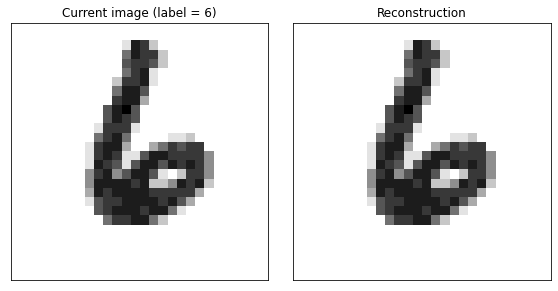

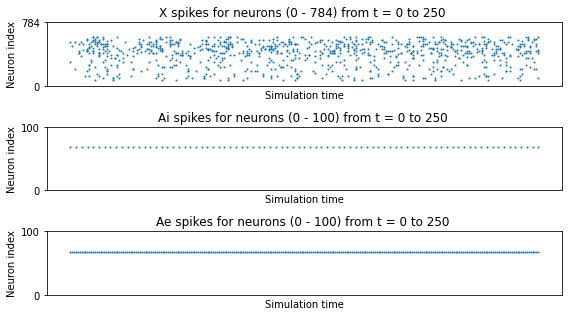

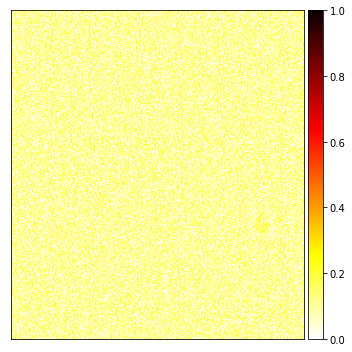

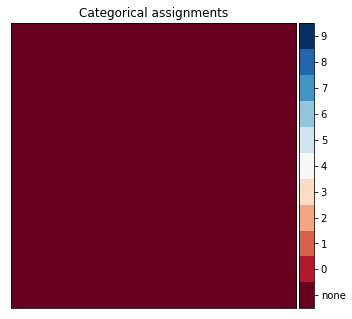

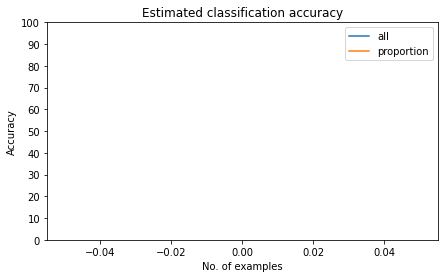

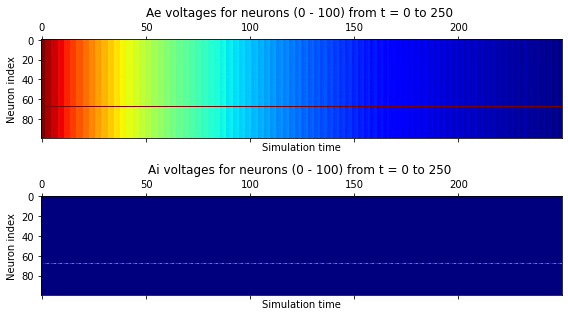


All activity accuracy: 11.20 (last), 11.20 (average), 11.20 (best)
Proportion weighting accuracy: 11.20 (last), 11.20 (average), 11.20 (best)


All activity accuracy: 96.60 (last), 53.90 (average), 96.60 (best)
Proportion weighting accuracy: 96.60 (last), 53.90 (average), 96.60 (best)


All activity accuracy: 100.00 (last), 69.27 (average), 100.00 (best)
Proportion weighting accuracy: 100.00 (last), 69.27 (average), 100.00 (best)


All activity accuracy: 100.00 (last), 76.95 (average), 100.00 (best)
Proportion weighting accuracy: 100.00 (last), 76.95 (average), 100.00 (best)


All activity accuracy: 100.00 (last), 81.56 (average), 100.00 (best)
Proportion weighting accuracy: 100.00 (last), 81.56 (average), 100.00 (best)


All activity accuracy: 100.00 (last), 84.63 (average), 100.00 (best)
Proportion weighting accuracy: 100.00 (last), 84.63 (average), 100.00 (best)


All activity accuracy: 100.00 (last), 86.83 (average), 100.00 (best)
Proportion weighting accuracy: 100.00 (last), 86.8

  0%|          | 0/100 [00:00<?, ?it/s]


All activity accuracy: 0.59
Proportion weighting accuracy: 0.59 

Testing complete.



In [7]:
gc.collect()

seed = 0
n_neurons = 100
n_clamp = 1
exc = 22.5
inh = 120
theta_plus = 0.05
progress_interval = 10
update_interval = 500
train = True
plot = True
gpu = True
device_id = 0

# Sets up Gpu use
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if gpu and torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
else:
    torch.manual_seed(seed)
    device = "cpu"
    if gpu:
        gpu = False

torch.set_num_threads(os.cpu_count() - 1)
print("Running on Device = ", device)

if not train:
    update_interval = n_test

n_classes = 10
n_sqrt = int(np.ceil(np.sqrt(n_neurons)))
start_intensity = intensity
per_class = int(n_neurons / n_classes)

# Build Diehl & Cook 2015 network.
network = DiehlAndCook2015(
    n_inpt=784,
    n_neurons=n_neurons,
    exc=exc,
    inh=inh,
    dt=dt,
    nu=[1e-10, 1e-3],  # 0.711
    norm=78.4,
    theta_plus=theta_plus,
    inpt_shape=(1, 28, 28),
)

# Directs network to GPU
if gpu:
    network.to("cuda")

# Voltage recording for excitatory and inhibitory layers.
exc_voltage_monitor = Monitor(network.layers["Ae"], ["v"], time=time, device=device)
inh_voltage_monitor = Monitor(network.layers["Ai"], ["v"], time=time, device=device)
network.add_monitor(exc_voltage_monitor, name="exc_voltage")
network.add_monitor(inh_voltage_monitor, name="inh_voltage")

# Load MNIST data.
"""
dataset = MNIST(
    PoissonEncoder(time=time, dt=dt),
    None,
    root=os.path.join("..", "..", "data", "MNIST"),
    download=True,
    transform=transforms.Compose(
        [transforms.ToTensor(), transforms.Lambda(lambda x: x * intensity)]
    ),
)
"""

# Create a dataloader to iterate and batch data
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)

# Record spikes during the simulation.
spike_record = torch.zeros(update_interval, time, n_neurons, device=device)

# Neuron assignments and spike proportions.
assignments = -torch.ones_like(torch.Tensor(n_neurons), device=device)
proportions = torch.zeros_like(torch.Tensor(n_neurons, n_classes), device=device)
rates = torch.zeros_like(torch.Tensor(n_neurons, n_classes), device=device)

# Sequence of accuracy estimates.
accuracy = {"all": [], "proportion": []}

# Labels to determine neuron assignments and spike proportions and estimate accuracy
labels = torch.empty(update_interval, device=device)

spikes = {}
for layer in set(network.layers):
    spikes[layer] = Monitor(network.layers[layer], state_vars=["s"], time=time)
    network.add_monitor(spikes[layer], name="%s_spikes" % layer)

# Train the network.
print("Begin training.\n")

inpt_axes = None
inpt_ims = None
spike_axes = None
spike_ims = None
weights_im = None
assigns_im = None
perf_ax = None
voltage_axes = None
voltage_ims = None

pbar = tqdm(total=n_train)
for (i, datum) in enumerate(dataloader):
    if i > n_train:
        break

    image = datum["encoded_image"]
    label = datum["label"]

    if i % update_interval == 0 and i > 0:
        # Get network predictions.
        all_activity_pred = all_activity(spike_record, assignments, n_classes)
        proportion_pred = proportion_weighting(
            spike_record, assignments, proportions, n_classes
        )

        # Compute network accuracy according to available classification strategies.
        accuracy["all"].append(
            100 * torch.sum(labels.long() == all_activity_pred).item() / update_interval
        )
        accuracy["proportion"].append(
            100 * torch.sum(labels.long() == proportion_pred).item() / update_interval
        )

        print(
            "\nAll activity accuracy: %.2f (last), %.2f (average), %.2f (best)"
            % (accuracy["all"][-1], np.mean(accuracy["all"]), np.max(accuracy["all"]))
        )
        print(
            "Proportion weighting accuracy: %.2f (last), %.2f (average), %.2f (best)\n"
            % (
                accuracy["proportion"][-1],
                np.mean(accuracy["proportion"]),
                np.max(accuracy["proportion"]),
            )
        )

        # Assign labels to excitatory layer neurons.
        assignments, proportions, rates = assign_labels(
            spike_record, labels, n_classes, rates
        )

    # Add the current label to the list of labels for this update_interval
    labels[i % update_interval] = label[0]

    # Run the network on the input.
    choice = np.random.choice(int(n_neurons / n_classes), size=n_clamp, replace=False)
    clamp = {"Ae": per_class * label.long() + torch.Tensor(choice).long()}
    if gpu:
        inputs = {"X": image.cuda().view(time, 1, 1, 28, 28)}
    else:
        inputs = {"X": image.view(time, 1, 1, 28, 28)}
    network.run(inputs=inputs, time=time, clamp=clamp)

    # Get voltage recording.
    exc_voltages = exc_voltage_monitor.get("v")
    inh_voltages = inh_voltage_monitor.get("v")

    # Add to spikes recording.
    spike_record[i % update_interval] = spikes["Ae"].get("s").view(time, n_neurons)

    # Optionally plot various simulation information.    
    if plot and i == 0:
        inpt = inputs["X"].view(time, 784).sum(0).view(28, 28)
        input_exc_weights = network.connections[("X", "Ae")].w
        square_weights = get_square_weights(
            input_exc_weights.view(784, n_neurons), n_sqrt, 28
        )
        square_assignments = get_square_assignments(assignments, n_sqrt)
        voltages = {"Ae": exc_voltages, "Ai": inh_voltages}

        inpt_axes, inpt_ims = plot_input(
            image.sum(1).view(28, 28), inpt, label=label, axes=inpt_axes, ims=inpt_ims
        )
        spike_ims, spike_axes = plot_spikes(
            {layer: spikes[layer].get("s").view(time, 1, -1) for layer in spikes},
            ims=spike_ims,
            axes=spike_axes,
        )
        weights_im = plot_weights(square_weights, im=weights_im)
        assigns_im = plot_assignments(square_assignments, im=assigns_im)
        perf_ax = plot_performance(accuracy, x_scale=update_interval, ax=perf_ax)
        voltage_ims, voltage_axes = plot_voltages(
            voltages, ims=voltage_ims, axes=voltage_axes
        )
        plt.pause(1e-8)

    network.reset_state_variables()  # Reset state variables.
    pbar.set_description_str("Train progress: ")
    pbar.update()

print("Progress: %d / %d \n" % (n_train, n_train))
print("Training complete.\n")

print("Testing....\n")

# Load MNIST data.
"""
test_dataset = MNIST(
    PoissonEncoder(time=time, dt=dt),
    None,
    root=os.path.join("..", "..", "data", "MNIST"),
    download=True,
    train=False,
    transform=transforms.Compose(
        [transforms.ToTensor(), transforms.Lambda(lambda x: x * intensity)]
    ),
)
"""

# Sequence of accuracy estimates.
accuracy = {"all": 0, "proportion": 0}

# Record spikes during the simulation.
spike_record = torch.zeros(1, int(time / dt), n_neurons, device=device)

# Train the network.
print("\nBegin testing\n")
network.train(mode=False)

pbar = tqdm(total=n_test)
for step, batch in enumerate(valid_dataset):
    if step > n_test:
        break
    # Get next input sample.
    inputs = {"X": batch["encoded_image"].view(int(time / dt), 1, 1, 28, 28)}
    if gpu:
        inputs = {k: v.cuda() for k, v in inputs.items()}

    # Run the network on the input.
    network.run(inputs=inputs, time=time, input_time_dim=1)

    # Add to spikes recording.
    spike_record[0] = spikes["Ae"].get("s").squeeze()

    # Convert the array of labels into a tensor
    label_tensor = torch.tensor(batch["label"], device=device)

    # Get network predictions.
    all_activity_pred = all_activity(
        spikes=spike_record, assignments=assignments, n_labels=n_classes
    )
    proportion_pred = proportion_weighting(
        spikes=spike_record,
        assignments=assignments,
        proportions=proportions,
        n_labels=n_classes,
    )

    # Compute network accuracy according to available classification strategies.
    #print("label: ", torch.sum(label_tensor.long()).item(), "pred: ", all_activity_pred.item())
    accuracy["all"] += float(torch.sum(label_tensor.long() == all_activity_pred).item())
    accuracy["proportion"] += float(
        torch.sum(label_tensor.long() == proportion_pred).item()
    )

    network.reset_state_variables()  # Reset state variables.

    pbar.set_description_str(
        f"Accuracy: {(max(accuracy['all'] ,accuracy['proportion'] ) / (step+1)):.3}"
    )
    pbar.update()

print("\nAll activity accuracy: %.2f" % (accuracy["all"] / n_test))
print("Proportion weighting accuracy: %.2f \n" % (accuracy["proportion"] / n_test))

print("Testing complete.\n")


# See label and prediction of validation dataset

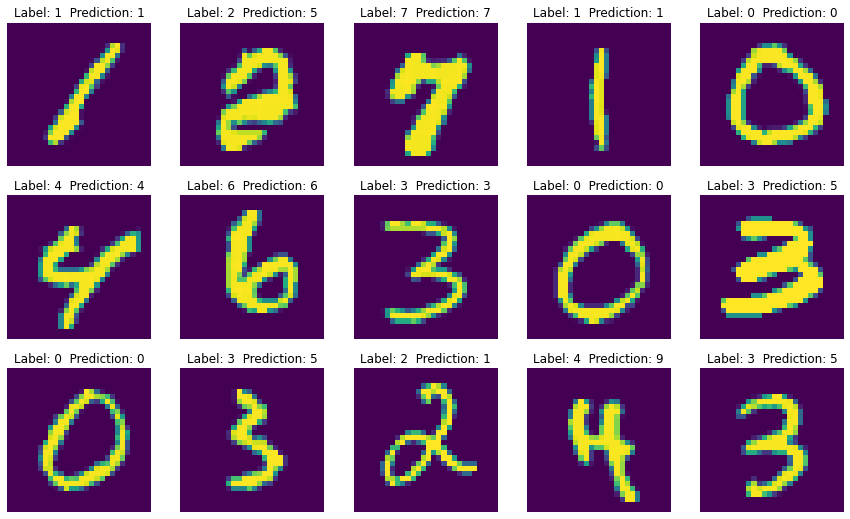

In [8]:
test_size = 15 #size of sampling
ncols = 5
if test_size%ncols == 0:
    nrows = test_size//ncols
else:
    nrows = test_size//ncols+1
height = nrows * 3
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, height))
ax = ax.ravel()

for step, batch in enumerate(valid_dataset):
    if step >= test_size:
        break
    # Get next input sample.
    inputs = {"X": batch["encoded_image"].view(int(time / dt), 1, 1, 28, 28)}
    if gpu:
        inputs = {k: v.cuda() for k, v in inputs.items()}

    # Run the network on the input.
    network.run(inputs=inputs, time=time, input_time_dim=1)

    # Add to spikes recording.
    spike_record[0] = spikes["Ae"].get("s").squeeze()

    # Convert the array of labels into a tensor
    label_tensor = torch.tensor(batch["label"], device=device)

    # Get network predictions.
    all_activity_pred = all_activity(
        spikes=spike_record, assignments=assignments, n_labels=n_classes
    )
    proportion_pred = proportion_weighting(
        spikes=spike_record,
        assignments=assignments,
        proportions=proportions,
        n_labels=n_classes,
    )
    
    #print("label: ", torch.sum(label_tensor.long()).item(), "pred: ", all_activity_pred.item())
    
    ax[step].imshow(torch.tensor(batch["image"]).to("cpu").detach().numpy().squeeze())
    ax[step].axis("off")
    title = ("Label: {}  Prediction: {}".format(torch.sum(label_tensor.long()).item(), all_activity_pred.item()))
    ax[step].set_title(title)
    network.reset_state_variables()  # Reset state variables.

# Prediction of test dataset and making submission file

In [9]:
model_preds_all_activity = []
model_preds_proportion = []

pbar = tqdm(total=len(X_test))
for step, batch in enumerate(test_dataset):
    # Get next input sample.
    inputs = {"X": batch["encoded_image"].view(int(time / dt), 1, 1, 28, 28)}
    if gpu:
        inputs = {k: v.cuda() for k, v in inputs.items()}

    # Run the network on the input.
    network.run(inputs=inputs, time=time, input_time_dim=1)

    # Add to spikes recording.
    spike_record[0] = spikes["Ae"].get("s").squeeze()

    # Convert the array of labels into a tensor
    #label_tensor = torch.tensor(batch["label"], device=device)

    # Get network predictions.
    all_activity_pred = all_activity(
        spikes=spike_record, assignments=assignments, n_labels=n_classes
    )
    proportion_pred = proportion_weighting(
        spikes=spike_record,
        assignments=assignments,
        proportions=proportions,
        n_labels=n_classes,
    )
    model_preds_all_activity.append(all_activity_pred.item())
    model_preds_proportion.append(proportion_pred.item())

    network.reset_state_variables()  # Reset state variables.
    
    pbar.set_description_str("Test progress: ")
    pbar.update()

  0%|          | 0/28000 [00:00<?, ?it/s]

In [10]:
submission["Label"] = model_preds_all_activity
submission.to_csv("submission.csv", index=False)